In [49]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
# file = 'sp500_data.csv'
file = 'aapl_data.csv'
# file = 'jnj_data.csv'
# file = "xom_data.csv"


<br>
Building LSTM model requires separation of stock price data into a trianing set and a test set<br>
This requires normalizing the data so that the values range from 0 to 1. <br>
Instead of taking the entirety of that data, we will focus the extraction of 80% of the data set as test set.<br>


In [50]:
def trainingSet(stockData):
    closePrice = stockData['Close']
    closeValues = closePrice.values
    trainingLen = math.ceil(len(closeValues)* 0.8)

    # MinMax Scaler: renomarlized into 2d array
    minMax = MinMaxScaler(feature_range=(0,1))
    scaleData = minMax.fit_transform(closeValues.reshape(-1,1))
    trainData = scaleData[0:trainingLen, :]
    xTrain, yTrain = [], []
    for i in range(60, len(trainData)):
        xTrain.append(trainData[i-60:i, 0])
        yTrain.append(trainData[i, 0])
    
    '''
    Convertaion featureData-> Xtrain and labelDate -> ytrain into 
    Numpy array as it is the data valid through tensorflow
    Then LSTM model requires a 3d array
    '''
    xTrain = np.array(xTrain) 
    yTrain = np.array(yTrain)
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    testData = scaleData[trainingLen-60: , :]
    xTest = []
    yTest = closeValues[trainingLen:]
    for i in range(60, len(testData)):
        xTest.append(testData[i-60:i,0])
    
    xTest = np.array(xTest)
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1],1))
    return xTrain, yTrain, xTest, yTest, minMax, trainingLen


<br>
Setting up LSTM network<br>
Model comprised of linear stack of layers, LSTM 100 network units, the return sequence will be same length<br>


In [51]:
def LSTMmodel(xTrain, yTrain, xTest, yTest, minMax):
    lstmModel = tf.keras.Sequential()
    lstmModel.add(layers.LSTM(100, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
    lstmModel.add(layers.LSTM(100, return_sequences=False))
    lstmModel.add(layers.Dense(25))
    lstmModel.add(layers.Dense(1))
    lstmModel.summary()

    # Training
    lstmModel.compile(optimizer='adam', loss='mean_squared_error')
    lstmModel.fit(xTrain, yTrain, batch_size=1, epochs=3)
    prediction = lstmModel.predict(xTest)
    prediction = minMax.inverse_transform(prediction)
   

    # print('************************YTEST************************\n')
    # print(yTest)
    # print('************************PREDICTION************************\n')
    # print(prediction)
    return prediction

In [52]:
def visualizeOutput(stockData, prediction, trainingLen):
    data = stockData.filter(['Close'])
    train = data[:trainingLen]
    validate = data[trainingLen:]
    validate['Predictions'] = prediction
    plot.figure(figsize=(16,8))
    plot.title('LSTM Model')
    plot.xlabel('Date')
    plot.ylabel('Closing Price USD$')
    plot.plot(train)
    plot.plot(validate[['Close', 'Predictions']])
    plot.legend(['Train', 'val', 'Predictions'], loc='lower right')
    plot.show()
    

In [53]:
def main():
    # reading single file as variable through the above attribute
    # train = pd.read_csv(f'CS5100_Project/data/{file}')
    train = pd.read_csv('../../data/aapl_data.csv')
    

    # Manipulation based on the Date and closing data
    train = train[['Date', 'Close']]
    # print(train.to_string())

    # formating data to ensure that the prices are floats and the date are in the proper format
    train = train.replace({'\$':''}, regex= True)
    train = train.astype({"Close": float})
    train["Date"] = pd.to_datetime(train["Date"], format="%Y/%m/%d")
    # check data type
    print(train.dtypes)
    train.index = train["Date"]
    train.head()

    #Plot closing price of stock data
    plot.figure(figsize=(10,6))
    plot.grid(True)
    plot.plot(train["Close"], label='Original')
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Close', fontsize=12)
    plot.title('Apple Closing Price')

    # Checking Trend and Seasonality
    plot.figure(figsize=(15,7))
    plot.grid(True)
    plot.plot(train["Close"], label='Original')
    plot.plot(train["Close"].rolling(window=12).mean(), color='red', label='Rolling mean')
    plot.plot(train["Close"].rolling(window=12).std(), color='green', label='Rolling std')
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Close', fontsize=12)
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')

    # Checking Trend and Seasonality
    from statsmodels.tsa.seasonal import seasonal_decompose 
    decomposition = seasonal_decompose(train['Close'], model='multiplicative', period=30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
        
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)

    # create trainingset
    xTrain, yTrain, xTest, yTest, minMax, trainingLen = trainingSet(train)
    prediction = LSTMmodel(xTrain, yTrain, xTest, xTest, minMax)
    visualizeOutput(train, prediction, trainingLen)

Date     datetime64[ns]
Close           float64
dtype: object
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
3968/3968 [==============================] - 51s 12ms/step - loss: 1.0291e-04
Epoch 2/3
3968/3968 [=========

C:\Users\moman\AppData\Local\Temp\ipykernel_6820\81833580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['Predictions'] = prediction


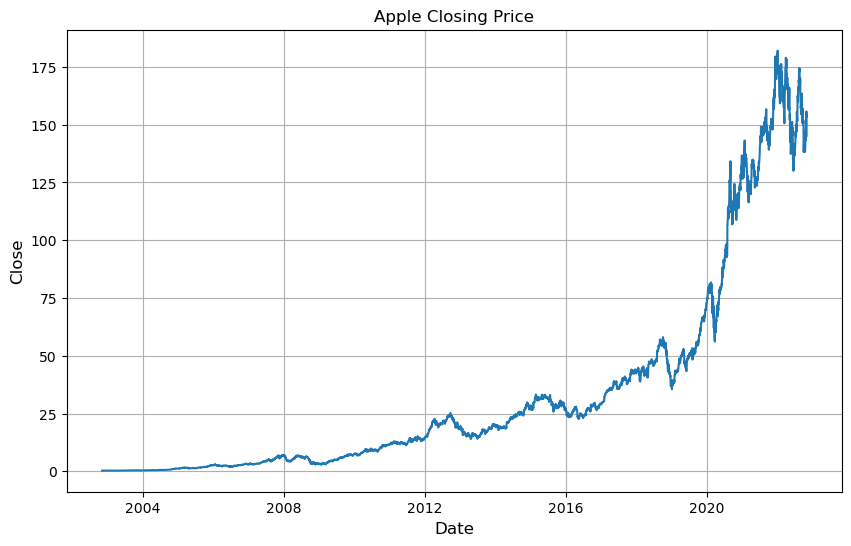

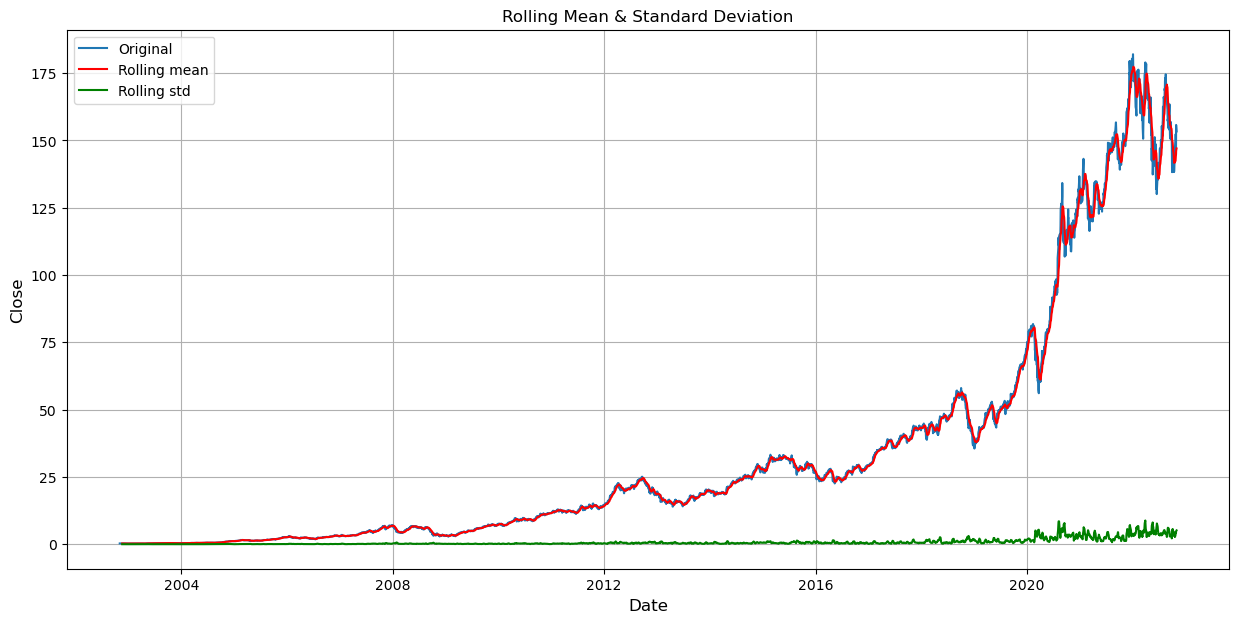

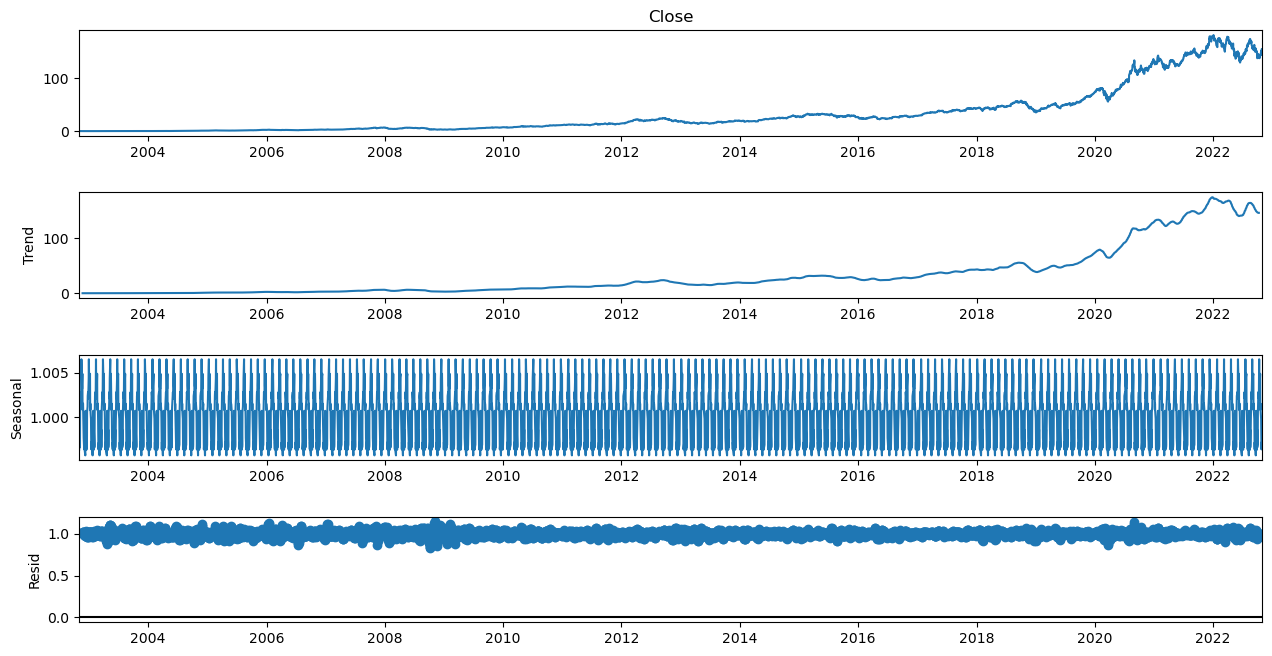

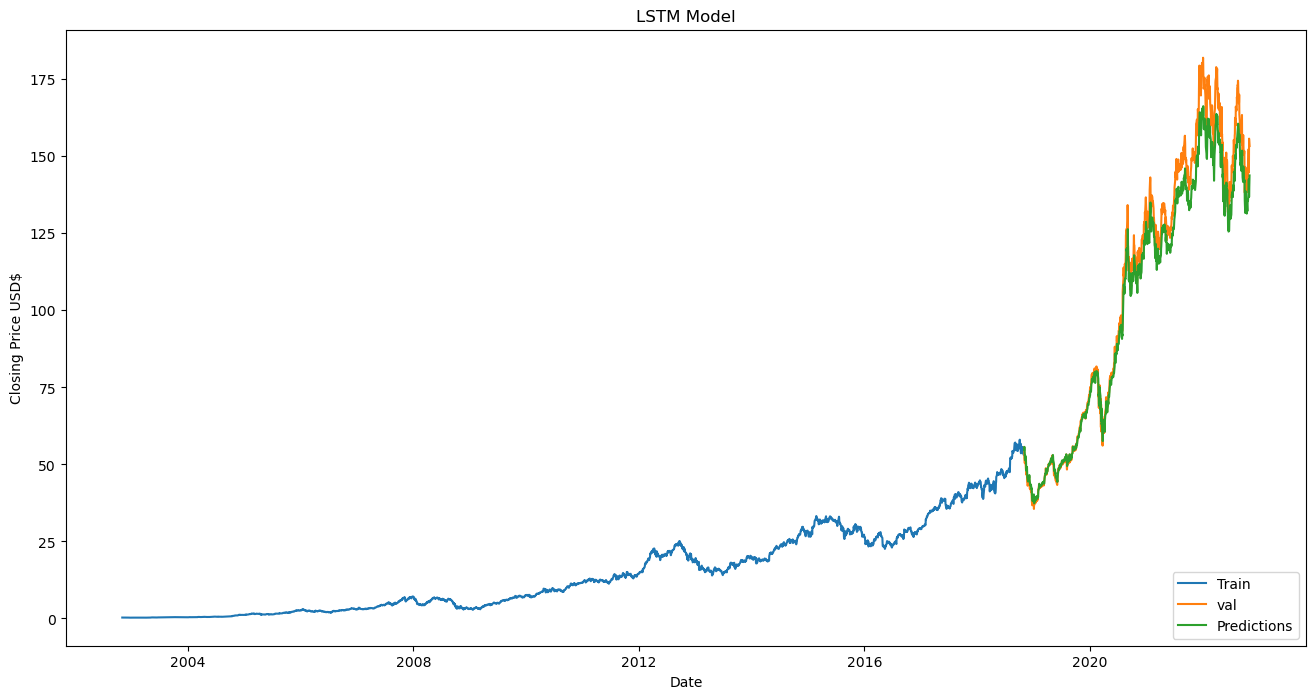

In [54]:
if __name__ == "__main__":
    main()